# Multi-agent supervisor

- 題材
  - Multi-agent supervisor(https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)
  - `Supervisor Agent`がユーザーからの質問を受け取り、Web検索を行う特化AgentとPythonコードを実行する特化Agentと連携してタスクを実行する。

![multi-agent-supervisor-1](./img/multi-agent-supervisor-1.png)

## セットアップ

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain-openai langchain_experimental python-dotenv langsmith

## 環境変数

In [2]:
import os

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langchain-study"

## モデルの定義

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## ステートの定義
`MessagesState`は`LangGraph`built-inのステータススキーマ。  
普通に`TypedDict`や`Pydantic`の`BaseModel`を継承して`State`クラスを定義して使うでも良い。

- `MessagesState`( https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate )

`langgraph/graph/message.py`
```python
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
```

In [4]:
from langgraph.graph import MessagesState, END

class State(MessagesState):  # MessagesStateを継承
    next: str

## Supervisor Agent(Node)を作成
次のWorker Nodeを選択するもしくは処理を終了するかを決定するNodeを作成する。

- `Command`(https://langchain-ai.github.io/langgraph/concepts/low_level/#command)
  - 状態を更新すると同時に、次に実行するNodeを指定する
  - 各Nodeが`Command`オブジェクトとして以下を返す。
    - 処理を渡す先のNode
    - ステータスの更新差分

- Command機能による動的なルーティング(https://zenn.dev/pharmax/articles/d91085d904657d)

In [5]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import END
from langgraph.types import Command


members = ["researcher", "coder"]  # ワーカーの選択肢を登録
options = members + ["FINISH"]  # ワーカーの選択肢に終了を追加

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]  # system_promptに対してStateに含まれるmessagesの内容を追加
    
    response = llm.with_structured_output(Router).invoke(messages)  # スキーマをRouterに指定してLLMに次の行き先を決定させる
    
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

## ツールの作成

### Web検索ツール(tavily_tool)
`Tavily`でWeb検索を行うツールを作成する。

`LangChain`では`BaseTool`を継承した`tools`のライブラリ(`langchain_community.tools`)が提供されており、ここではその中から`Tavily`でWeb検索を行う`TavilySearchResults`を使用する。

- `langchain_community.tools`(https://python.langchain.com/api_reference/community/tools.html)
- `BaseTool`(https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.BaseTool.html#langchain_core.tools.base.BaseTool)
- `TavilySearchResults`(https://python.langchain.com/api_reference/community/tools/langchain_community.tools.tavily_search.tool.TavilySearchResults.html)

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

### Pythonコード実行ツール(python_repl_tool)
Pythonコードを実行するツールを作成する。
結果出力もこのツールで`print()`を実行して行う。

In [7]:
from typing import Annotated
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


# This executes code locally, which can be unsafe
repl = PythonREPL()

@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

## Worker Nodeの作成
`Supervisor Agent`から呼び出されるWorker Nodeを作成する。

In [8]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

### research_node
`create_react_agent()`を使ってWeb検索を行う`research_agent`(`ReAct Agent`)を作成し、それを使ってタスクを実行するNodeを`research_node()`という関数で定義する。

In [9]:
research_agent = create_react_agent(llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math.")


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

### code_node
`create_react_agent()`を使ってPythonコードの実行を担う`code_agent`(`ReAct Agent`)を作成し、それを使ってタスクを実行するNodeを`code_node()`という関数で定義する。  
★`research_node`の結果を踏まえてLLMがmessageを生成するという操作も行う。

In [10]:
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
# code_agent = create_react_agent(llm, tools=[python_repl_tool]) # promptを追加しないとLLMがresearch_nodeの結果を踏まえて新たな文章を生成する。
code_agent = create_react_agent(llm, tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.") # promptを追加することでLLMにresearch_nodeから受け取った結果を弄らせない

def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

## グラフのコンパイル

関数として定義した`supervisor`と`create_react_agent()`を使って作成した`ReAct Agent`を含む関数`research_node`と`code_node`の3つをNodeとしてグラフに追加し、コンパイルする。

In [11]:
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

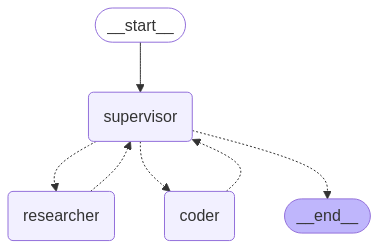

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## 実行
エージェントにユーザーからのリクエストを渡して実行する。

In [13]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:861fce0d-fc52-cbeb-5662-1354fcf7d154',), {'agent': {'messages': [AIMessage(content="I can't perform calculations, but I can help you find the information you need. If you're looking for the square root of 42, you can easily find it using a calculator or a math tool. Would you like to know more about square roots or any related concepts?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 98, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BKS7N6hRC8OMBYB4dzERIZgiiwPWV', 'finish_reason': 'stop', 'logprobs': None}, id='run-10190410-5206-4597-8e05-2b9dcb9fa14b-0', usage_metadata={'input_tokens'

Python REPL can execute arbitrary code. Use with caution.


(('coder:f6a2266f-a8a2-0a23-903b-87696841a8e0',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AM2DTWcg1hmixqIXS7aMzfiA', 'function': {'arguments': '{"code":"import math\\nmath.sqrt(42)"}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 168, 'total_tokens': 192, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKS7PSaqSbNMEtJMPXzdTnkwl0QSG', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a1353643-616c-4480-9e2f-7537a7480218-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nmath.sqrt(42)'}, 'id': 'call_AM2DTWcg1hmixqIXS7aMzfiA', 'type': 'tool_call'}], usage_m

In [14]:
print(graph.invoke({"messages": [("user", "What's the square root of 42?")]})["messages"][-1].content)

The square root of 42 is approximately 6.4807.


In [15]:
print(graph.invoke({"messages": [("user", "k8sとは何ですか?")]})["messages"][-1].content)
# graph.invoke({"messages": [("user", "What's k8s?")]})

Kubernetes（K8s）は、コンテナ化されたアプリケーションのデプロイ、スケーリング、および管理を行うためのオープンソースのコンテナオーケストレーションシステムです。主な機能には、コンテナの自動デプロイと管理、スケーリングの自動化、負荷分散、サービスの可用性を保証するためのヘルスチェックなどがあります。

K8sは、アプリケーションをパッケージ化して分離し、マルチクラウドやハイブリッドクラウド環境でのオーケストレーションを容易にします。これにより、企業は異なるクラウド環境間でアプリケーションを展開するための共通プラットフォームを持ち、基盤となるクラウドインフラの複雑さを抽象化することができます。


In [16]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:8867dba1-5b49-9a70-17aa-1ee03b21d721',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AMw07g2DHiiTwX8CrkZQYVLI', 'function': {'arguments': '{"query": "latest GDP of New York 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_SLt9xn5z7QG7axMng5MWEnSS', 'function': {'arguments': '{"query": "latest GDP of California 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 104, 'total_tokens': 170, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BKS7rslO8kkGPHTcT4AdyTkETmQcQ', 'finish_reason': '